In [1]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box, Sequence, Dict
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from src.commons import methods
import statistics

from src.rl_environments.env_impr3 import EnvImpr3
from src.model_approaches.analytical.oracle_fix_n import OracleFix_n
from src.model_approaches.analytical.oracle_var_n import OracleVar_n
from src.model_approaches.analytical.pto_fix_n import PTO_Fix_n
from src.model_approaches.analytical.pto_var_n import PTO_Var_n
from src.model_approaches.rl.ppo import PPO

from src.commons import generate_data, methods
from src.commons.constants import AlphaEstimator, TravelTimeDist
import os
import pickle
from pathlib import Path

from collections import OrderedDict

## Train Config

In [2]:
PARAM_ESTIMATOR = AlphaEstimator.MAX_LIKELI

TRAIN_CONFIG = {
    'alpha_range': np.arange(0.1, 7.0, 0.1).tolist(),
    'beta_range': np.arange(0.1, 5.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(5, 40)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

PPO_TIME_STEPS = 2_000_000
PPO_ENV_CLASS = EnvImpr3


## Model Options

In [3]:
oracle_models = [OracleVar_n(), OracleFix_n(n=3), OracleFix_n(n=5)]
user_models = [PPO(EnvClass=EnvImpr3, config=TRAIN_CONFIG, timesteps=PPO_TIME_STEPS),
               PTO_Var_n(param_estimator=PARAM_ESTIMATOR),
               PTO_Fix_n(n=3, param_estimator=PARAM_ESTIMATOR),
               PTO_Fix_n(n=5, param_estimator=PARAM_ESTIMATOR)]

cost_results_df = pd.DataFrame(columns=['Test Name', 'PPO', 'PTO_Var_n', 'Oracle_Var_n', 'PTO_Fix_n_3', 'Oracle_Fix_n_3', 'PTO_Fix_n_5', 'Oracle_Fix_n_5'])
observed_n_results_df = pd.DataFrame(columns=['Test Name', 'PPO', 'PTO_Var_n', 'Oracle_Var_n'])

[INFO] Loaded trained PPO model from:
/Users/preetkaria/PycharmProjects/when_to_leave/models/PPO_EnvImpr3_b56d0_2M.zip


## Common Methods

In [4]:
def getResultColumnName(column: str, columns_to_visualize: list, type: str) -> str:
    for col in columns_to_visualize:
        if type in col and column in col:
            return col
    print(f"No matching column found for {column} with type {type}")

def testFlow(test_df_path: str, models: list):
    # Load test data
    test_df = pd.DataFrame()
    with open(test_df_path, 'rb') as f:
        test_df =pickle.load(f)
        
    # Evaluate models
    
    columns_to_visualize = []
    for model in models:
        print(f'Evaluating {model.prediction_keys()}')
        columns_to_visualize += model.prediction_keys()
        
        new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
        for i, col_name in enumerate(model.prediction_keys()):
            test_df[col_name] = new_cols[i]
            print(col_name, test_df[col_name].mean())
            
    # Save the test df with predictions
    test_df_path = Path(test_df_path)
    test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
    test_df.to_pickle(test_df_path)
    
    return test_df, columns_to_visualize

def evaluateResults(test_df: pd.DataFrame, columns_to_visualize: list, test_name: str, 
                    cost_results_df: pd.DataFrame, observed_n_results_df: pd.DataFrame):
    means = test_df[columns_to_visualize].mean()
    cost_results_row = {'Test Name': test_name}
    for cost_column in cost_results_df.columns:
        if cost_column == 'Test Name':
            continue
        mean_col = getResultColumnName(cost_column, columns_to_visualize, 'cost')
        cost_results_row[cost_column] = means.get(mean_col)
    cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
    
    observed_n_results_rows = {'Test Name': test_name}
    for observed_n_column in observed_n_results_df.columns:
        if observed_n_column == 'Test Name':
            continue
        mean_col = getResultColumnName(observed_n_column, columns_to_visualize, 'observed_n')
        observed_n_results_rows[observed_n_column] = means.get(mean_col)
    observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)
    
    return cost_results_df, observed_n_results_df

## Test on Simulated Data

In [5]:
base_sim_test = OrderedDict()
base_sim_test['low alpha from 0.1 to 1.0'] = {
    'alpha_range': np.arange(0.1, 1.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 40)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['medium alpha from 1.0 to 3.0'] = {
    'alpha_range': np.arange(1.0, 3.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 40)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['high alpha from 3.0 to 5.0'] = {
    'alpha_range': np.arange(3.0, 5.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 40)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['high beta from 3 to 5'] = {
    'alpha_range': np.arange(0.1, 3.0, 0.1).tolist(),
    'beta_range': np.arange(3.0, 5.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 40)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}
sim_tests = OrderedDict()
for travel_time in TravelTimeDist:
    for test_name, config in base_sim_test.items():
        new_test_name = f"{test_name} with {travel_time.name.lower()} travel time"
        new_config = config.copy()
        new_config['travel_time'] = travel_time
        sim_tests[new_test_name] = new_config


In [6]:
for test_name, config in sim_tests.items():
    print(f'Running test: {test_name}')
    
    test_df_path = generate_data.generate(config=config, row_count=10_000)
    
    pandarallel.initialize(progress_bar=True)
        
    test_df = pd.DataFrame()
    with open(test_df_path, 'rb') as f:
        test_df =pickle.load(f)
        
    # Evaluate models
    
    columns_to_visualize = []
    for model in user_models + oracle_models:
        print(f'Evaluating {model.prediction_keys()}')
        columns_to_visualize += model.prediction_keys()
        
        new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
        for i, col_name in enumerate(model.prediction_keys()):
            test_df[col_name] = new_cols[i]
            print(col_name, test_df[col_name].mean())
            
    # Save the test df with predictions
    test_df_path = Path(test_df_path)
    test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
    test_df.to_pickle(test_df_path)

    cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)
    
    
        
        
    
    

Running test: low alpha from 0.1 to 1.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/e3a7b_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 4.003231441825221
observed_n_PPO_EnvImpr3_b56d0_2M 6.2107
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 4.071889132405377
observed_n_PTO_Var_n 5.964
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 7.328311526482266
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 8.14565344747998
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 2.8887466494752325
observed_n_Oracle_Var_n 6.1134
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 3.364769762696193
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 5.801534916909557
Running test: medium alpha from 1.0 to 3.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/a44af_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1811744699.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1811744699.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)


cost_PPO_EnvImpr3_b56d0_2M 8.10107247032744
observed_n_PPO_EnvImpr3_b56d0_2M 10.1598
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 8.12494289981977
observed_n_PTO_Var_n 9.8417
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 13.557500232888179
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 13.084959987052914
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 6.007713644192471
observed_n_Oracle_Var_n 10.0155
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 7.423972548894422
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 9.11232023992136
Running test: high alpha from 3.0 to 5.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/b101f_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 11.025298795631782
observed_n_PPO_EnvImpr3_b56d0_2M 11.386
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 10.909150812081391
observed_n_PTO_Var_n 10.9297
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 17.31989203429461
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 16.36685506846361
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 7.965295209984093
observed_n_Oracle_Var_n 11.0688
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 10.082228396508036
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 11.629783617043296
Running test: high beta from 3 to 5 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/3a078_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 13.778455778639726
observed_n_PPO_EnvImpr3_b56d0_2M 9.8349
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 13.898372028418851
observed_n_PTO_Var_n 9.3166
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 19.31193228760856
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 18.057125121599558
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 10.625463166796859
observed_n_Oracle_Var_n 9.9486
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 12.750841703013892
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 13.735757232996926
Running test: low alpha from 0.1 to 1.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0140e_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 4.991679376073878
observed_n_PPO_EnvImpr3_b56d0_2M 10.1325
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 5.200731014890329
observed_n_PTO_Var_n 9.6539
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 9.483396291240823
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 8.541790319665003
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 4.211943484694844
observed_n_Oracle_Var_n 10.3467
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 5.153306117485193
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 5.48145517036437
Running test: medium alpha from 1.0 to 3.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/d418b_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 6.573352749825314
observed_n_PPO_EnvImpr3_b56d0_2M 16.8
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 6.832364840094655
observed_n_PTO_Var_n 16.3343
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 15.524564923577428
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 13.489872773148134
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 5.596029678136904
observed_n_Oracle_Var_n 16.5111
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 8.560760765071679
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 8.452527110881178
Running test: high alpha from 3.0 to 5.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/85366_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 8.025220447716586
observed_n_PPO_EnvImpr3_b56d0_2M 18.6868
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 8.018548146876926
observed_n_PTO_Var_n 18.1834
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 19.321846045877408
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 16.637986199145804
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 6.9390252368398375
observed_n_Oracle_Var_n 18.1934
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 11.277623987038385
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 11.008014483804224
Running test: high beta from 3 to 5 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/43359_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 11.739416119625174
observed_n_PPO_EnvImpr3_b56d0_2M 16.1878
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 12.171304688695242
observed_n_PTO_Var_n 15.3871
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 23.38784595965484
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 20.340957975517874
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 9.98285828368456
observed_n_Oracle_Var_n 15.9889
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 14.346106368843035
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 14.019428860422858
Running test: low alpha from 0.1 to 1.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/a84d0_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 3.0413050649680216
observed_n_PPO_EnvImpr3_b56d0_2M 3.6907
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 3.157987907767868
observed_n_PTO_Var_n 3.5658
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 5.574111800212138
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 11.866613074769505
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 1.1991909511890388
observed_n_Oracle_Var_n 3.1335
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 1.3071659890511058
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 11.002316869763291
Running test: medium alpha from 1.0 to 3.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/d1b52_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 6.928992853054989
observed_n_PPO_EnvImpr3_b56d0_2M 4.0939
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 6.644965396049956
observed_n_PTO_Var_n 3.95
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 9.301744813319983
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 16.085723904588612
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 4.143526499312055
observed_n_Oracle_Var_n 3.4401
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 4.314467565864227
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 15.218188450874402
Running test: high alpha from 3.0 to 5.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0340d_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 10.17881148782331
observed_n_PPO_EnvImpr3_b56d0_2M 4.3917
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 9.618893151770823
observed_n_PTO_Var_n 4.1483
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 12.01666694173179
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 17.633705319753066
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 6.670962987256578
observed_n_Oracle_Var_n 3.6661
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 7.061515249970702
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 16.627494473428246
Running test: high beta from 3 to 5 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/4057c_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 9.319567875074732
observed_n_PPO_EnvImpr3_b56d0_2M 4.4245
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 9.20031372523585
observed_n_PTO_Var_n 4.2079
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 11.625613788506989
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 16.58279290195975
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 8.074375919411258
observed_n_Oracle_Var_n 3.8877
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 8.532635319571167
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 16.236826292270205


## Test Prof Data

In [7]:
test_df_path = Path(methods.file_path('prof_full_data.pkl', dir_name='data/prof_data_test/'))
test_name = "Prof Data Test"

pandarallel.initialize(progress_bar=True)
        
test_df = pd.DataFrame()
with open(test_df_path, 'rb') as f:
    test_df =pickle.load(f)


# Evaluate models

columns_to_visualize = []
for model in user_models:
    print(f'Evaluating {model.prediction_keys()}')
    columns_to_visualize += model.prediction_keys()
    
    new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
    for i, col_name in enumerate(model.prediction_keys()):
        test_df[col_name] = new_cols[i]
        print(col_name, test_df[col_name].mean())
        
# Save the test df with predictions
test_df_path = Path(test_df_path)
test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
test_df.to_pickle(test_df_path)

cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 14.077771008227568
observed_n_PPO_EnvImpr3_b56d0_2M 16.526
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 14.274019641719478
observed_n_PTO_Var_n 16.1669
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 26.405796761524012
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 22.468632054456194
No matching column found for Oracle_Var_n with type cost
No matching column found for Oracle_Fix_n_3 with type cost
No matching column found for Oracle_Fix_n_5 with type cost
No matching column found for Oracle_Var_n with type observed_n


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1811744699.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1811744699.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)


## Test Bicycle Data

In [8]:
test_df_path = Path(methods.file_path('bicycle_data.pkl', dir_name='data/non_gamma_bicyle_test'))
test_name = "Bicycle Data Test"

pandarallel.initialize(progress_bar=True)
        
test_df = pd.DataFrame()
with open(test_df_path, 'rb') as f:
    test_df =pickle.load(f)
    
# Evaluate models

columns_to_visualize = []
for model in user_models:
    print(f'Evaluating {model.prediction_keys()}')
    columns_to_visualize += model.prediction_keys()
    
    new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
    for i, col_name in enumerate(model.prediction_keys()):
        test_df[col_name] = new_cols[i]
        print(col_name, test_df[col_name].mean())
        
# Save the test df with predictions
test_df_path = Path(test_df_path)
test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
test_df.to_pickle(test_df_path)

cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr3_b56d0_2M', 'observed_n_PPO_EnvImpr3_b56d0_2M']


cost_PPO_EnvImpr3_b56d0_2M 18.362613762074606
observed_n_PPO_EnvImpr3_b56d0_2M 36.077777777777776
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 19.143514138555556
observed_n_PTO_Var_n 35.44444444444444
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 34.33659797694444
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 29.870037397500003
No matching column found for Oracle_Var_n with type cost
No matching column found for Oracle_Fix_n_3 with type cost
No matching column found for Oracle_Fix_n_5 with type cost
No matching column found for Oracle_Var_n with type observed_n


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1811744699.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1811744699.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)


In [9]:
display(cost_results_df.head())
display(observed_n_results_df.head())
cost_results_df.to_csv(methods.file_path('finla_test_cost_results.csv', dir_name='results'), index=False)
observed_n_results_df.to_csv(methods.file_path('finla_test_observed_n_results.csv', dir_name='results'), index=False)

,Test Name,PPO,PTO_Var_n,Oracle_Var_n,PTO_Fix_n_3,Oracle_Fix_n_3,PTO_Fix_n_5,Oracle_Fix_n_5
0,low alpha from 0.1 to 1.0 with uniform travel ...,4.003231,4.071889,2.888747,7.328312,3.364770,8.145653,5.801535
1,medium alpha from 1.0 to 3.0 with uniform trav...,8.101072,8.124943,6.007714,13.557500,7.423973,13.084960,9.112320
2,high alpha from 3.0 to 5.0 with uniform travel...,11.025299,10.909151,7.965295,17.319892,10.082228,16.366855,11.629784
3,high beta from 3 to 5 with uniform travel time,13.778456,13.898372,10.625463,19.311932,12.750842,18.057125,13.735757
4,low alpha from 0.1 to 1.0 with low travel time,4.991679,5.200731,4.211943,9.483396,5.153306,8.541790,5.481455


,Test Name,PPO,PTO_Var_n,Oracle_Var_n
0,low alpha from 0.1 to 1.0 with uniform travel ...,6.2107,5.9640,6.1134
1,medium alpha from 1.0 to 3.0 with uniform trav...,10.1598,9.8417,10.0155
2,high alpha from 3.0 to 5.0 with uniform travel...,11.3860,10.9297,11.0688
3,high beta from 3 to 5 with uniform travel time,9.8349,9.3166,9.9486
4,low alpha from 0.1 to 1.0 with low travel time,10.1325,9.6539,10.3467


## Average Cost Comparison Plot

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


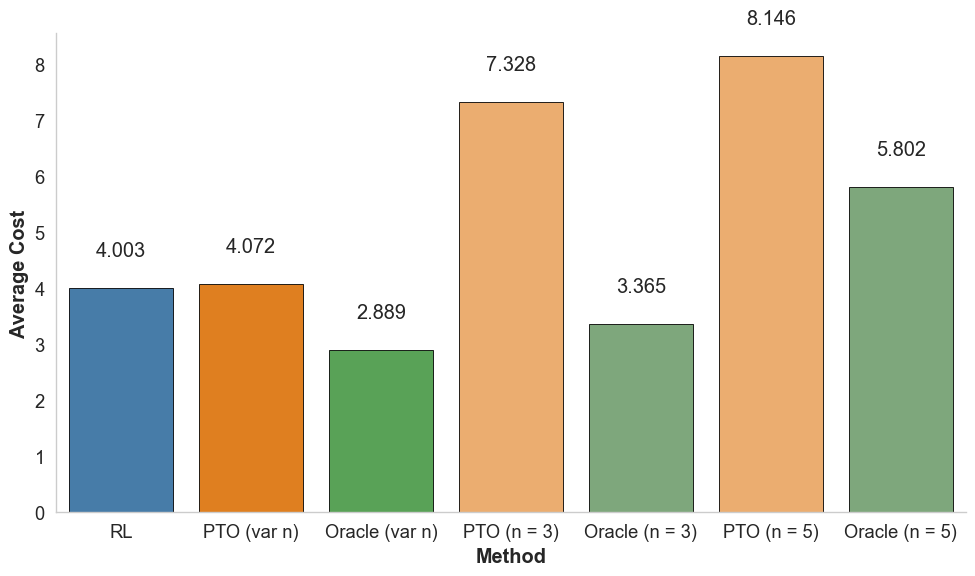

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


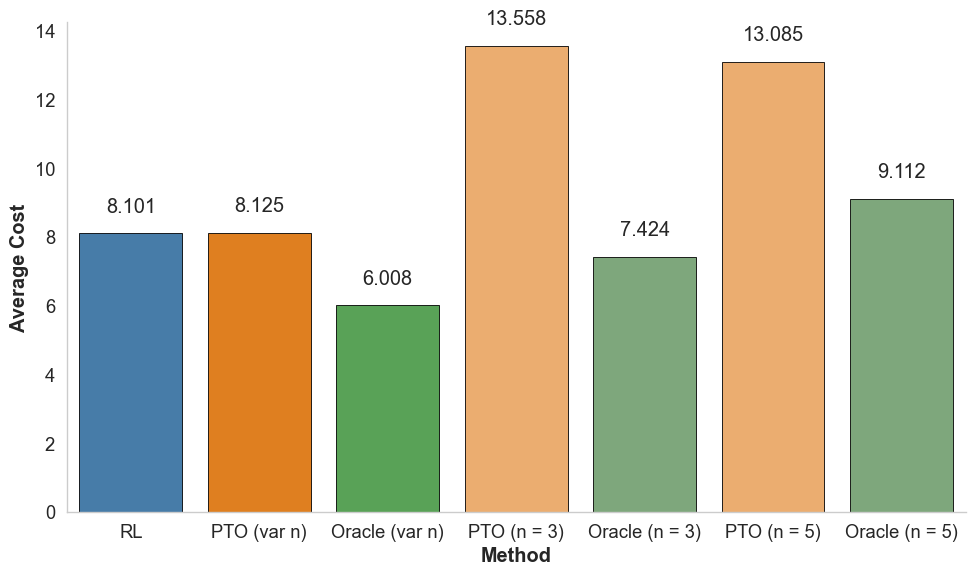

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


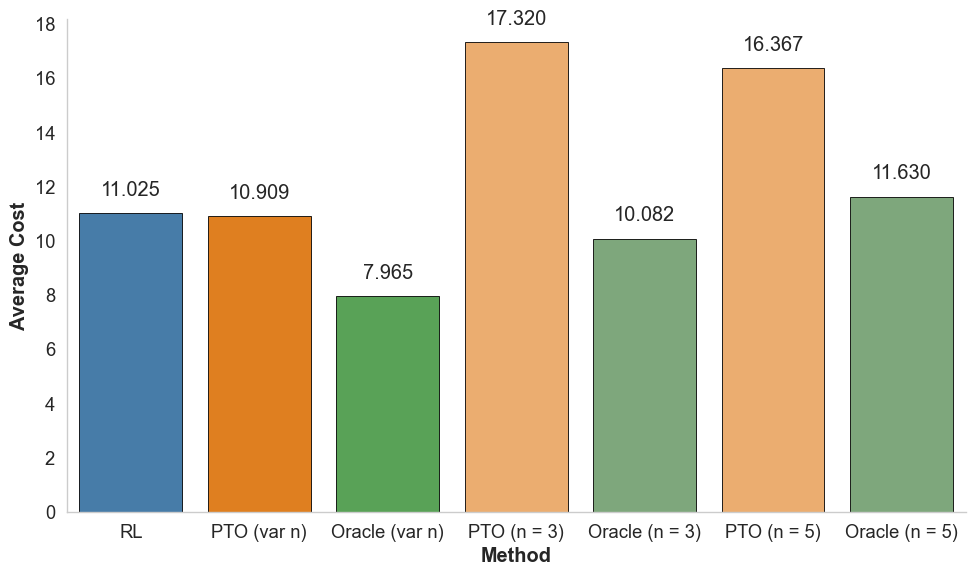

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


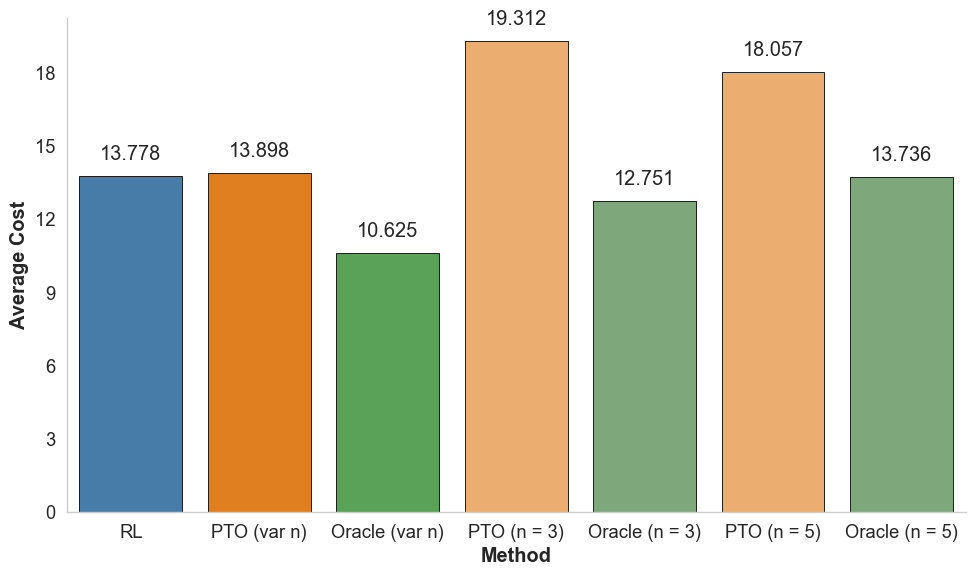

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


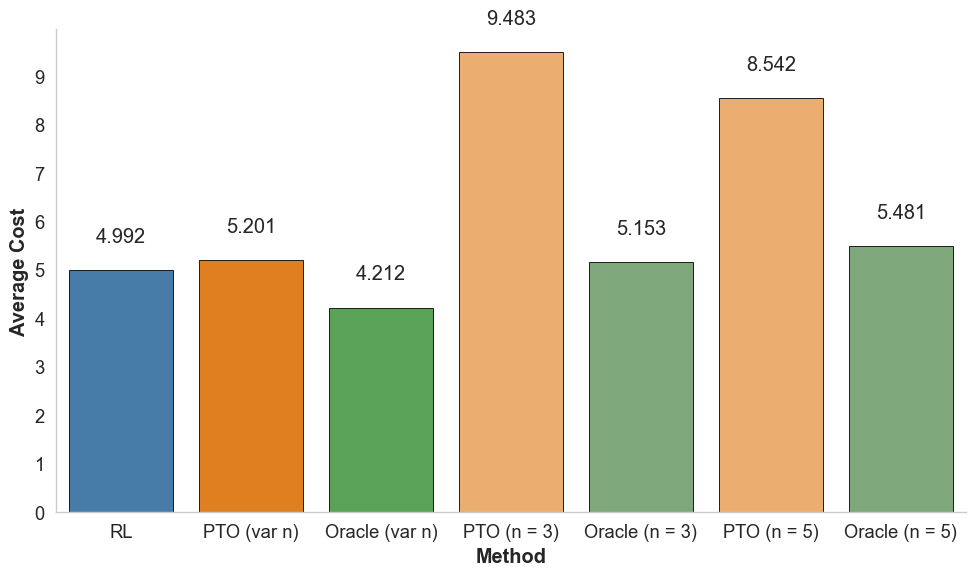

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


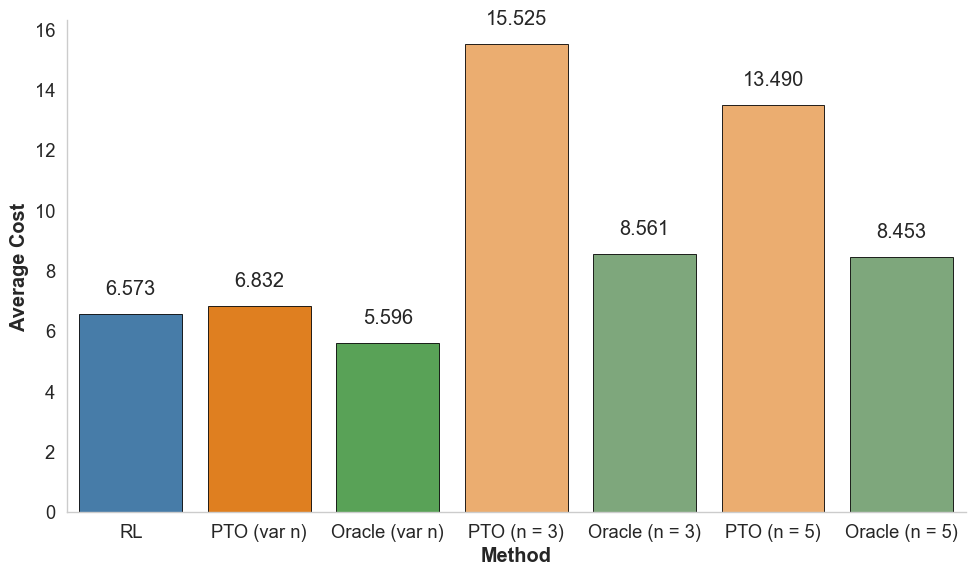

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


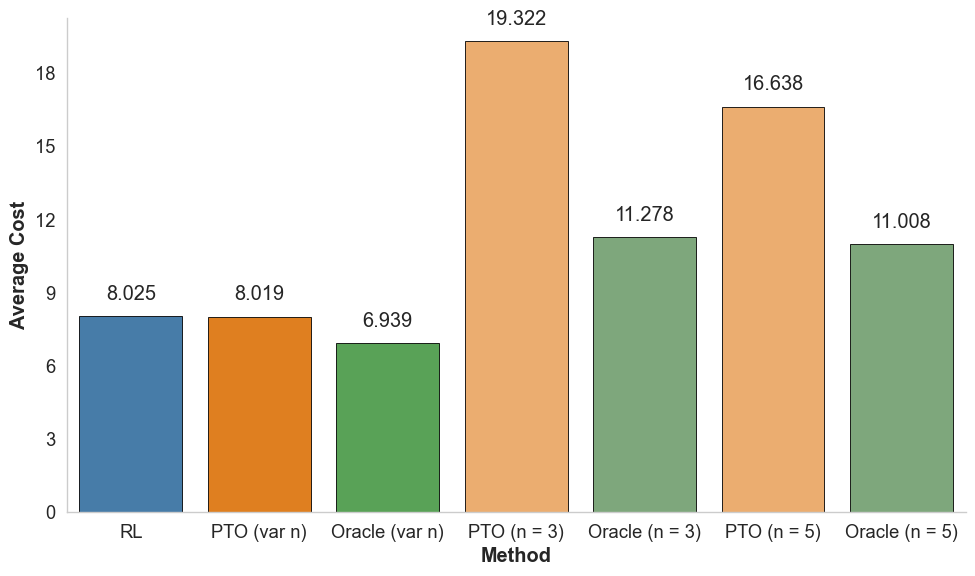

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


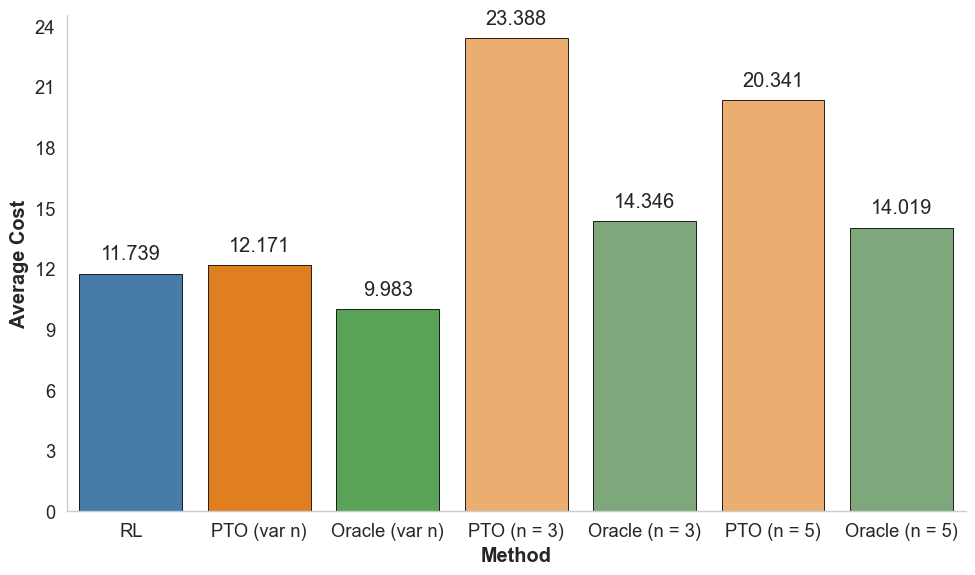

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


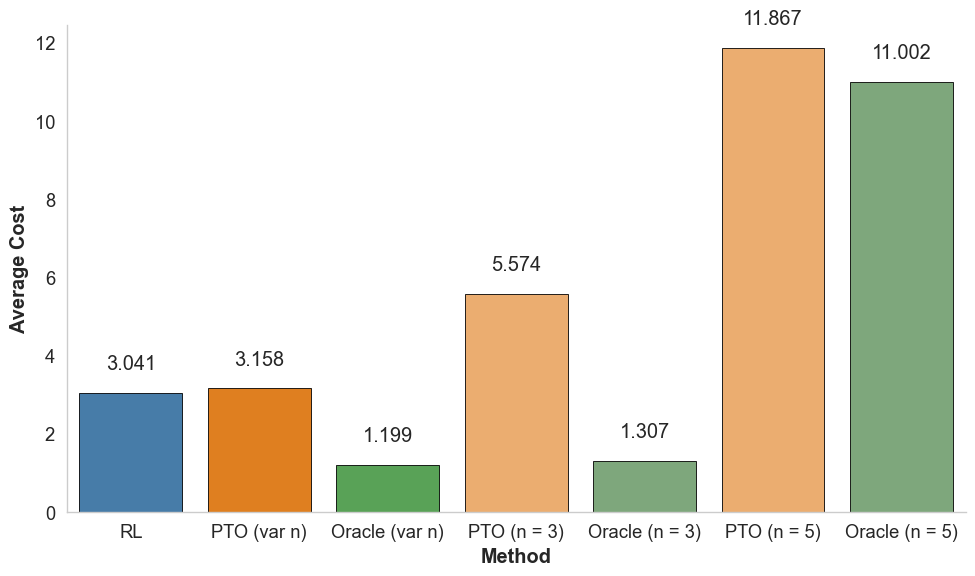

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


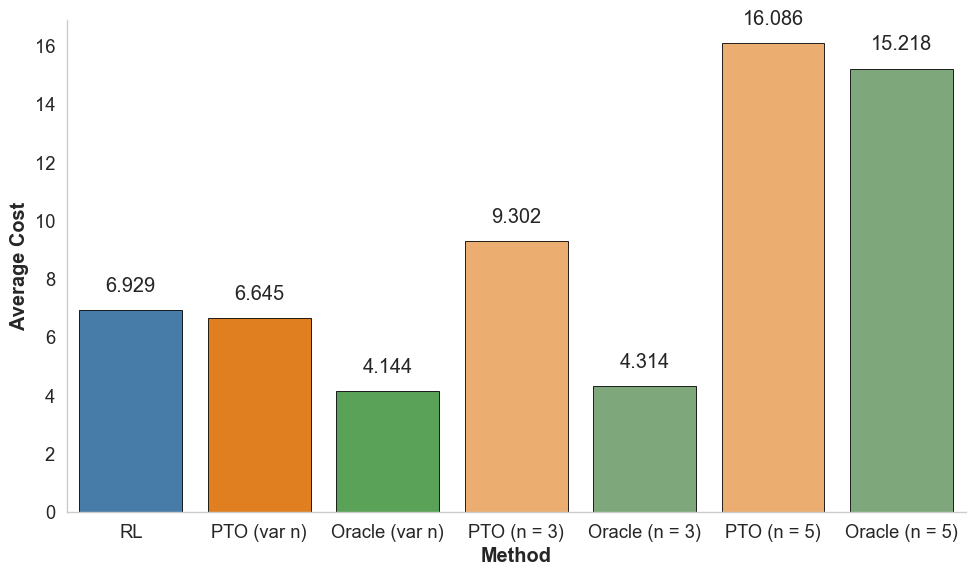

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


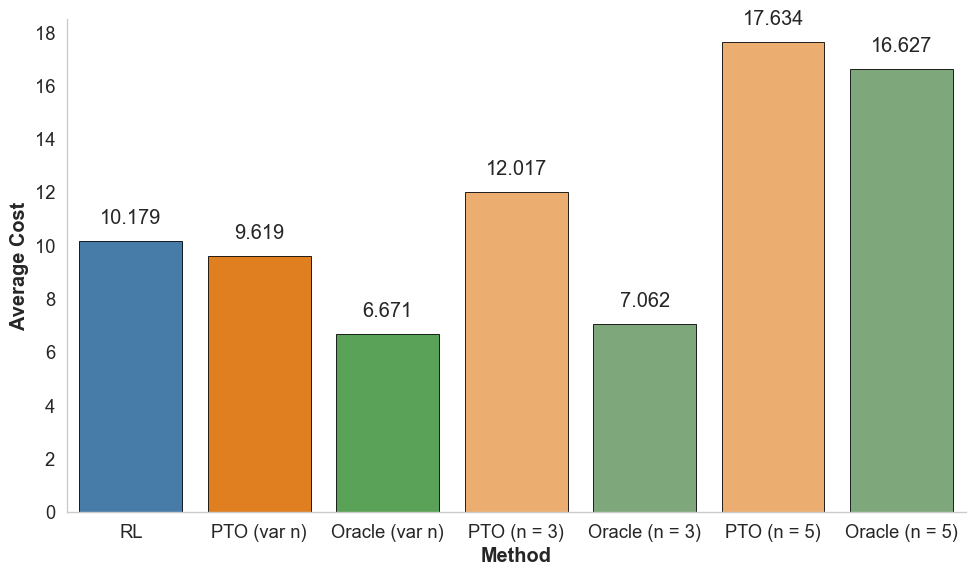

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


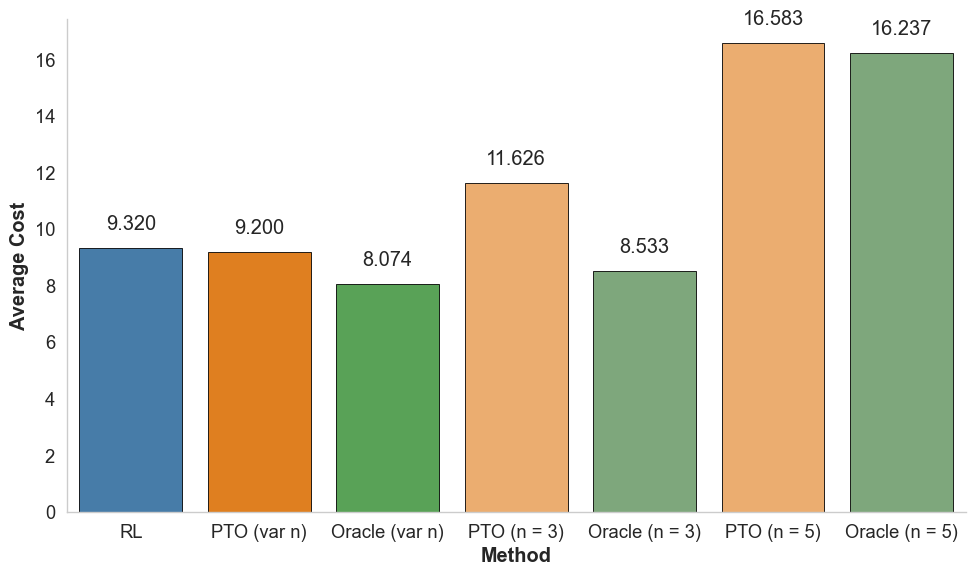

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


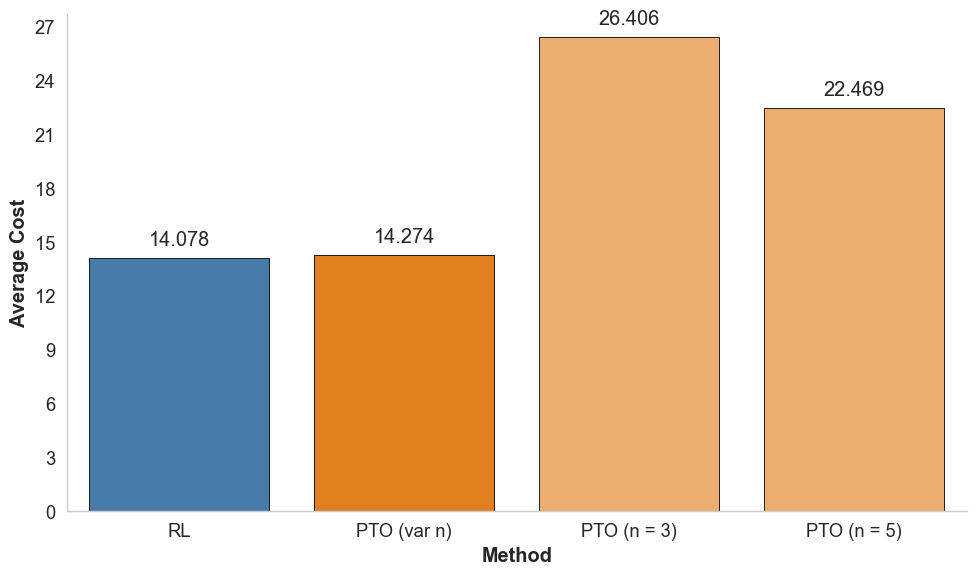

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/314685168.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)


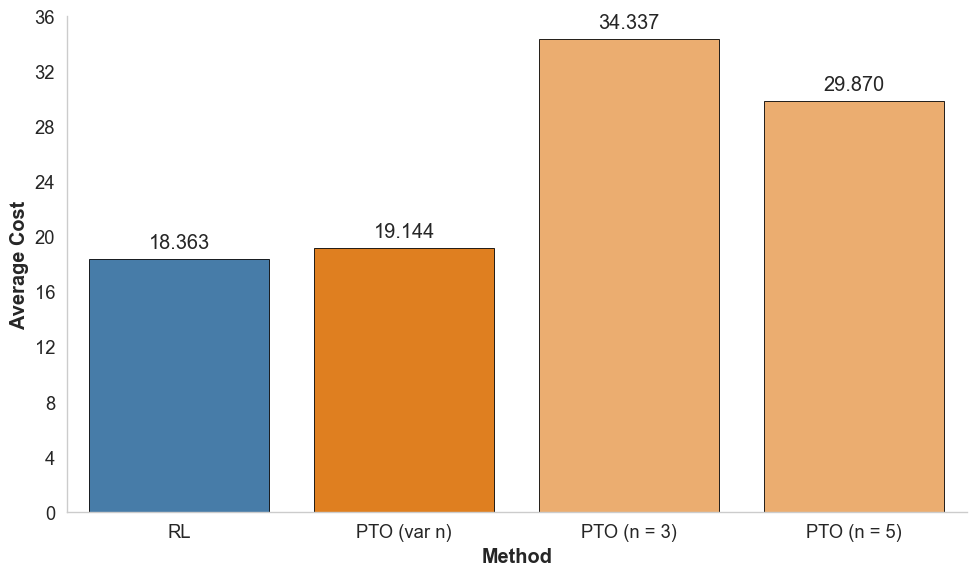

In [10]:
method_map = {'PPO': 'RL', 'PTO_Var_n': 'PTO (var n)', 'Oracle_Var_n': 'Oracle (var n)',
              'PTO_Fix_n_3': 'PTO (n = 3)', 'Oracle_Fix_n_3': 'Oracle (n = 3)',
              'PTO_Fix_n_5': 'PTO (n = 5)', 'Oracle_Fix_n_5': 'Oracle (n = 5)'}
color_map = {'PPO': '#377eb8', 'PTO_Var_n': '#ff7f00', 'Oracle_Var_n': '#4daf4a',
              'PTO_Fix_n_3': "#ffad5bff", 'Oracle_Fix_n_3': "#77ae75ff",
              'PTO_Fix_n_5': "#ffad5bff", 'Oracle_Fix_n_5': "#77ae75ff"}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import math
from matplotlib.ticker import MaxNLocator

sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})


for row in cost_results_df.itertuples():
    
    test_name = row._1
    methods_list = list(cost_results_df.columns)[1:]
    
    if test_name == "Bicycle Data Test" or test_name == "Prof Data Test":
        methods_list = ['PPO', 'PTO_Var_n', 'PTO_Fix_n_3', 'PTO_Fix_n_5']
        
    method_list = [m for m in methods_list if not math.isnan(getattr(row, m))]
    
    costs = [getattr(row, col) for col in methods_list]
    
    
    plt.figure(figsize=(10, 6))
    
    short_labels = [method_map[m] for m in methods_list]
    
    colors = [color_map[m] for m in methods_list]

   
    ax = sns.barplot(x=short_labels, y=costs, palette=colors, edgecolor='black', linewidth=0.6)
    ax.set_ylabel('Average Cost')
    ax.set_xlabel('Method')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(False)
    
    sns.despine()
   
   
    for i, v in enumerate(costs):
        ax.text(i, v + 0.5, f"{v:.3f}", ha='center', va='bottom')
    
    plt.tight_layout()
    
    config = sim_tests.get(test_name)
   
    file_name = f'cost_comparison_{test_name.replace(" ", "_").lower()}'
    plt.savefig(methods.file_path(f'{file_name}.png', dir_name='figures'))
    json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
    plt.show()

## Averge Cost Compiled

,Test Name,Method,Average Cost
0,low alpha from 0.1 to 1.0 with uniform travel ...,PPO,4.003231
1,medium alpha from 1.0 to 3.0 with uniform trav...,PPO,8.101072
2,high alpha from 3.0 to 5.0 with uniform travel...,PPO,11.025299
3,high beta from 3 to 5 with uniform travel time,PPO,13.778456
4,low alpha from 0.1 to 1.0 with low travel time,PPO,4.991679


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/4102391351.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i for i in range(1, 13)])


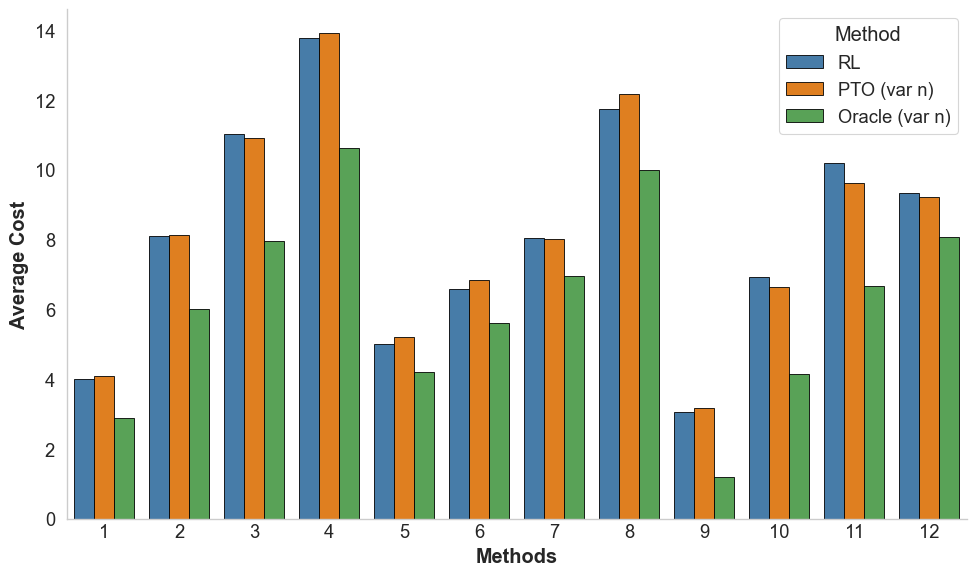

<Figure size 640x480 with 0 Axes>

In [11]:
# obersved n compiled plot

# Preserve 'Test Name' so it can be used on x-axis
cost_results_df_melted = cost_results_df.melt(
	id_vars='Test Name',
	var_name='Method',
	value_name='Average Cost'
)
display(cost_results_df_melted.head())
cost_results_df_melted = cost_results_df_melted[
    cost_results_df_melted['Test Name'].str.contains('with', na=False)
    & ~cost_results_df_melted['Method'].str.contains('fix', case=False, na=False)
]
sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=cost_results_df_melted,
    x='Test Name',
    y='Average Cost',
    hue='Method',
    palette=color_map,
    edgecolor='black',
    linewidth=0.6
)
ax.set_ylabel('Average Cost')
ax.set_xlabel('Methods')
ax.set_xticklabels([i for i in range(1, 13)])
ax.tick_params(axis='x', length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
mapped_labels = [method_map.get(l, l) for l in labels]
legend = ax.legend(handles, mapped_labels, title='Method')
plt.tight_layout()
plt.show()
plt.savefig(methods.file_path('cost_comparison_compiled.png', dir_name='figures'))

# Average Obeserved n individual Plot

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


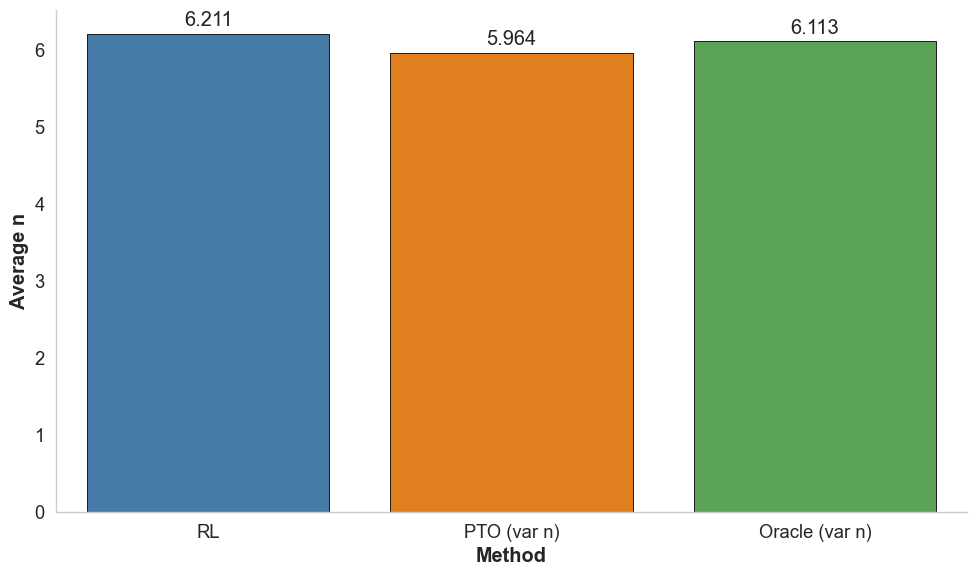

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


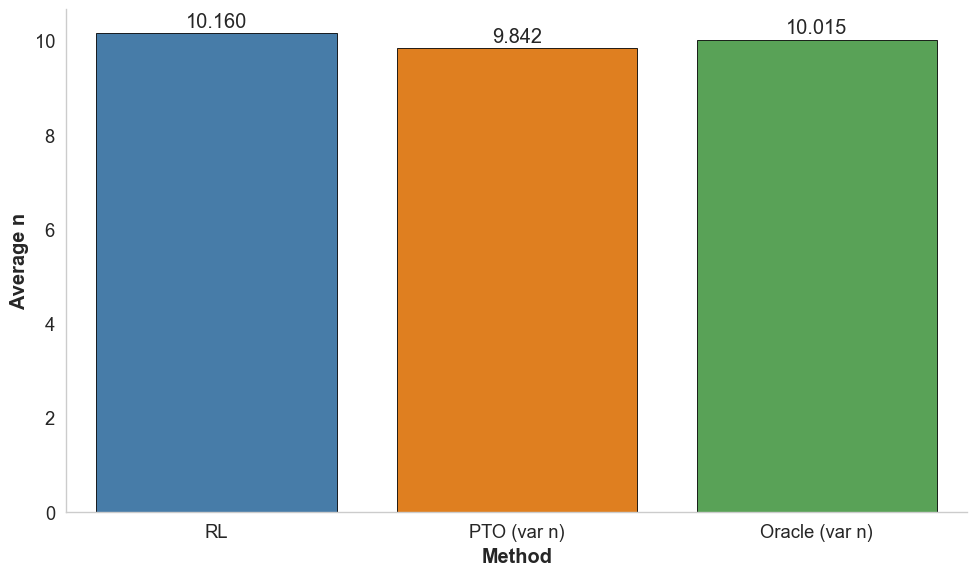

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


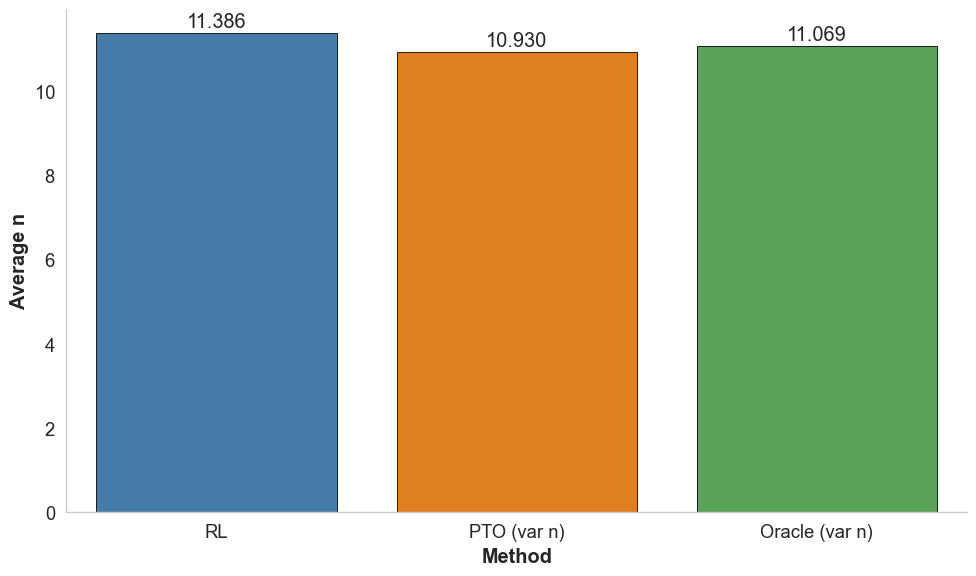

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


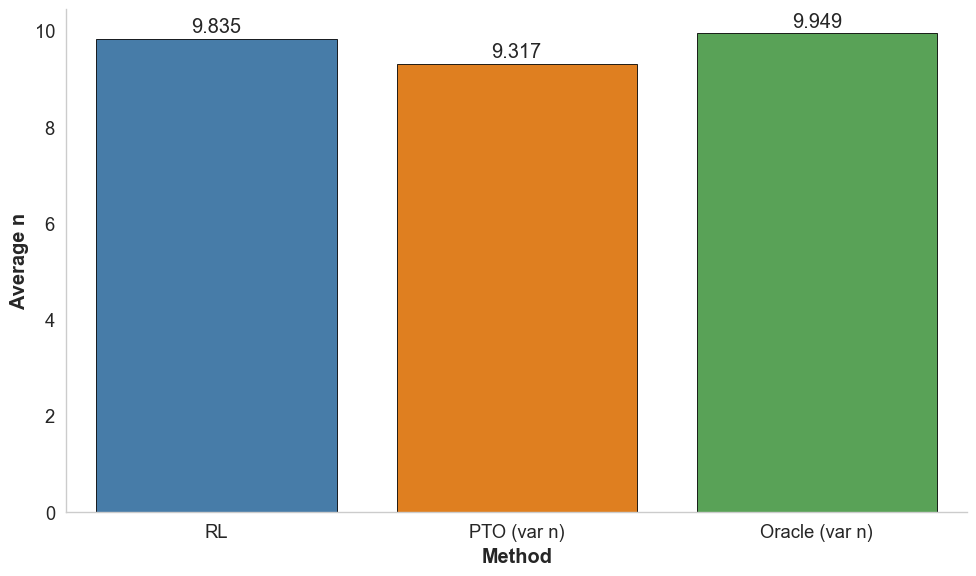

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


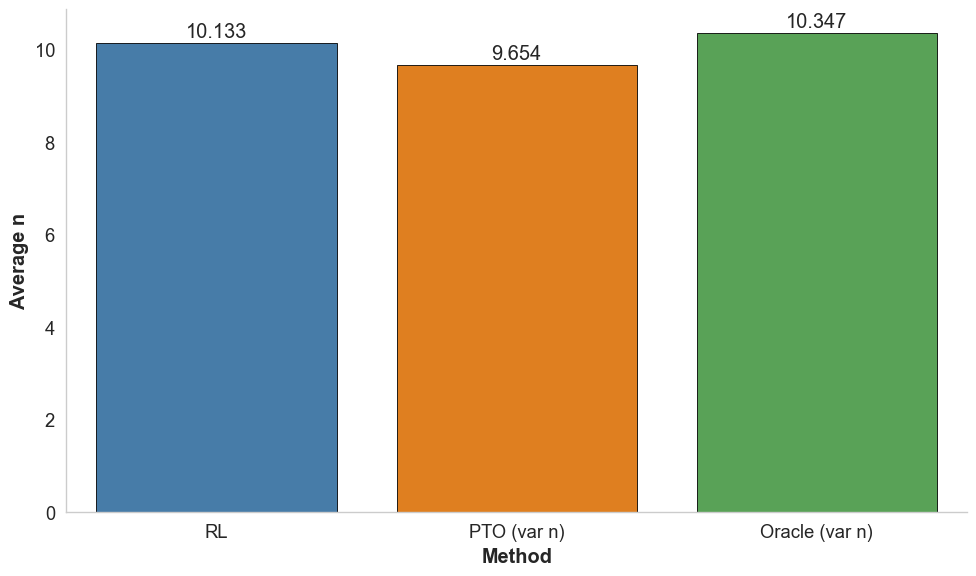

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


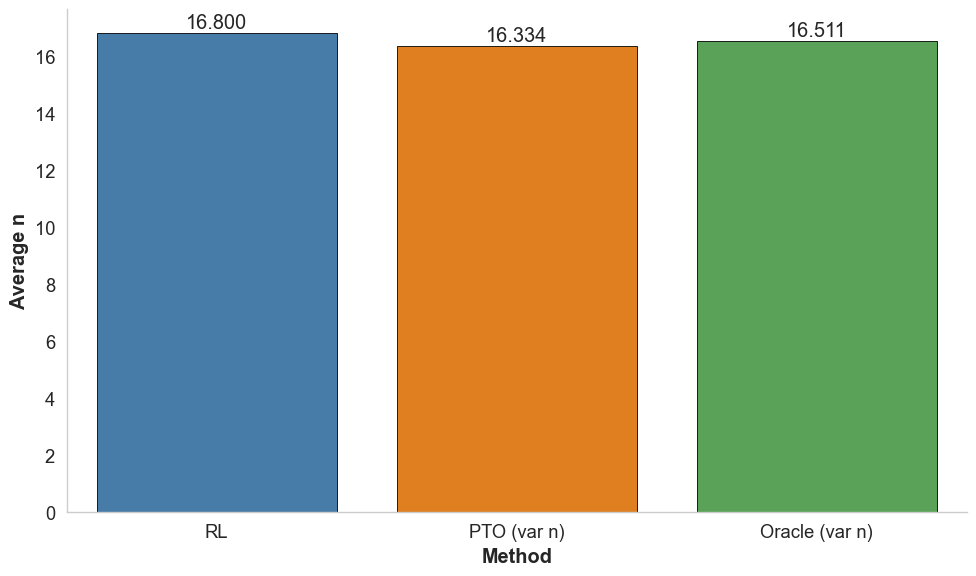

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


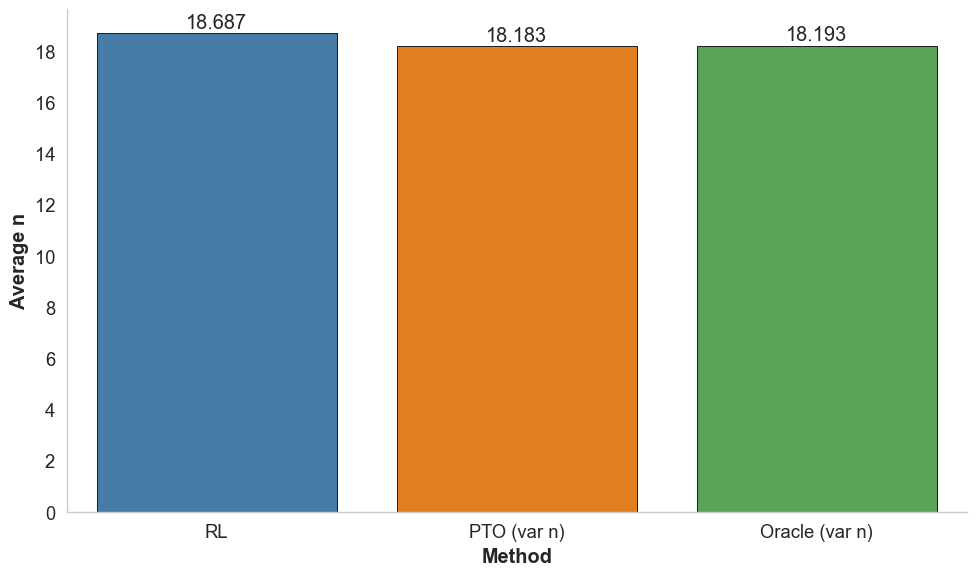

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


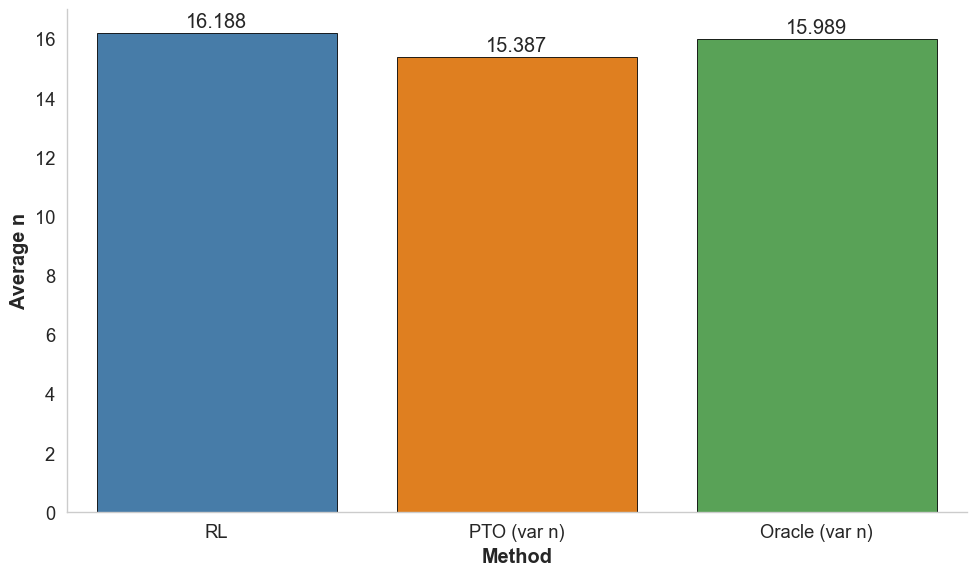

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


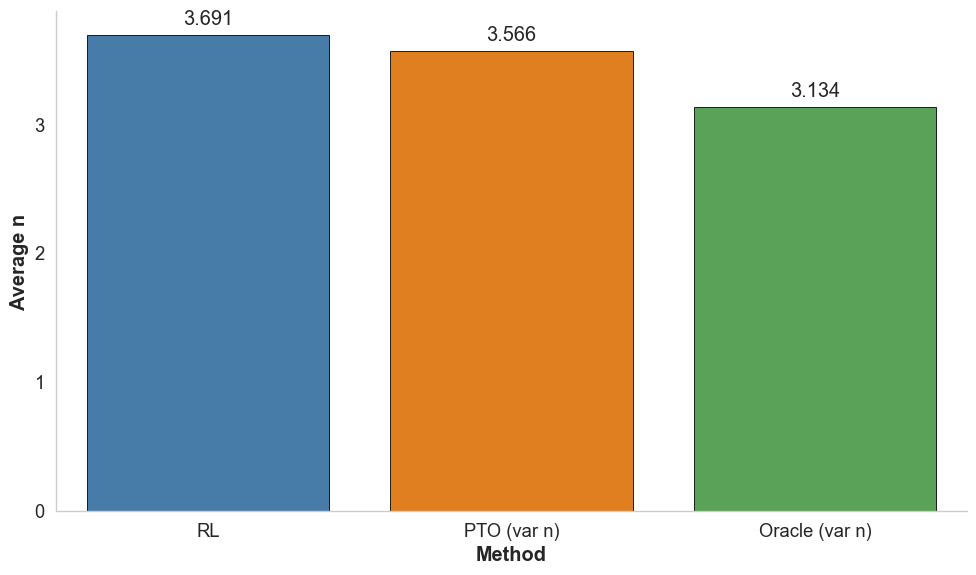

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


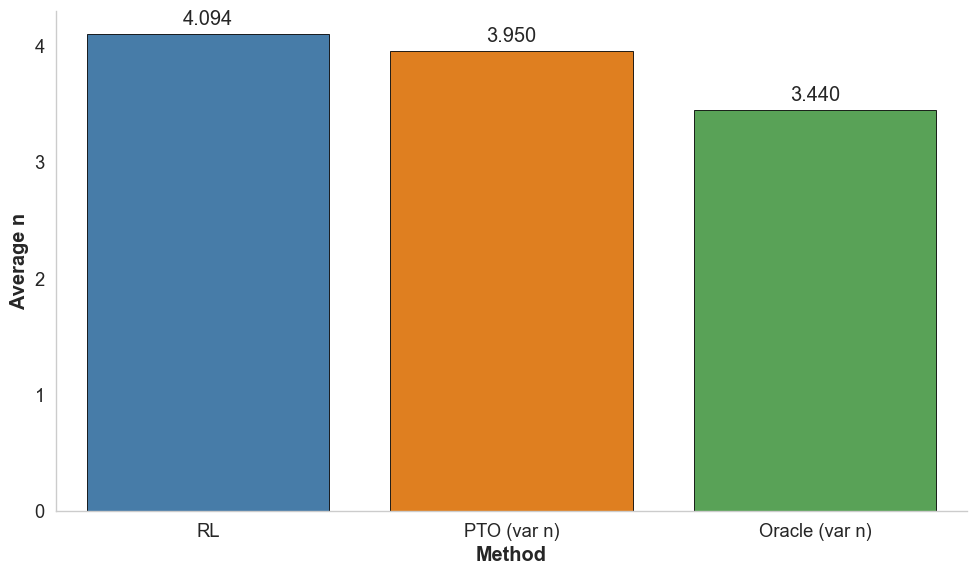

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


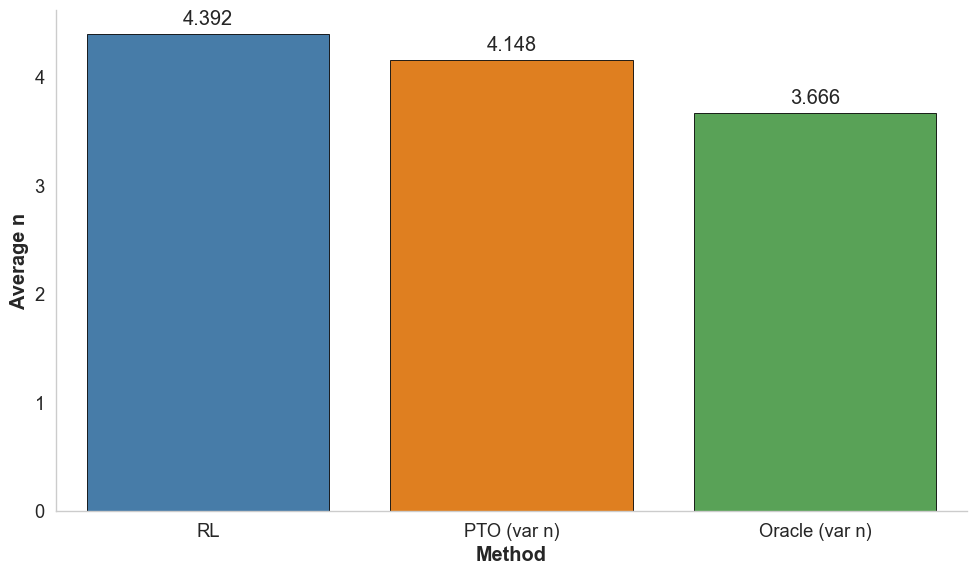

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


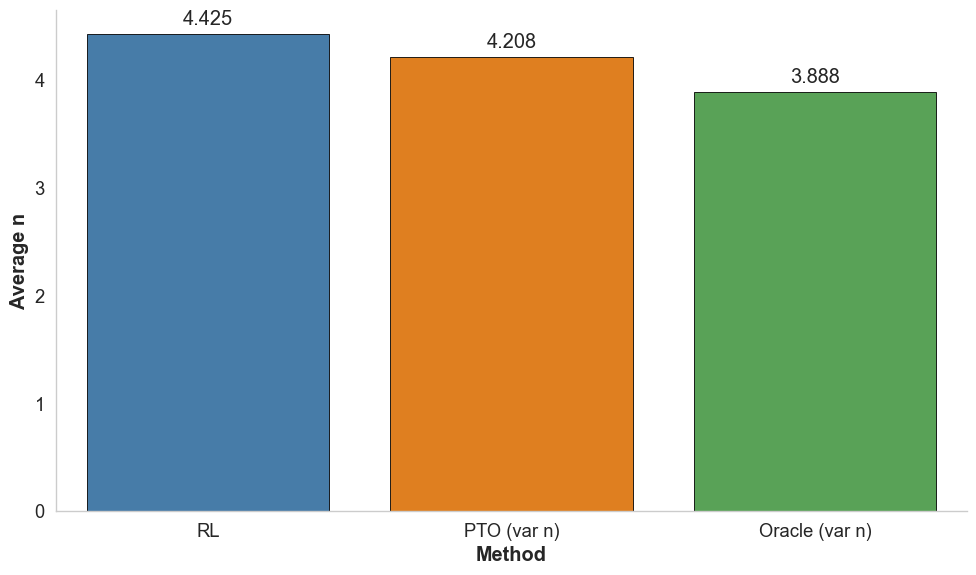

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


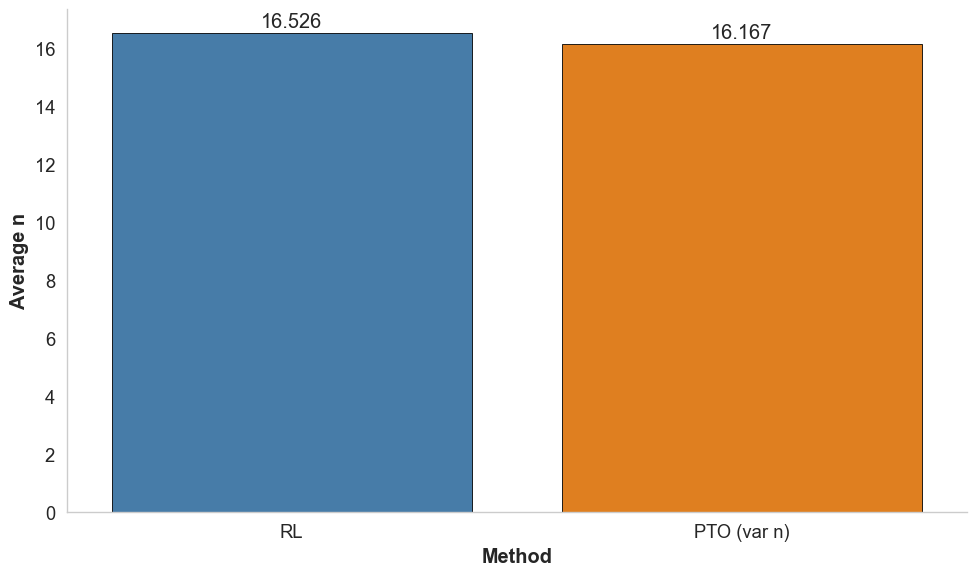

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


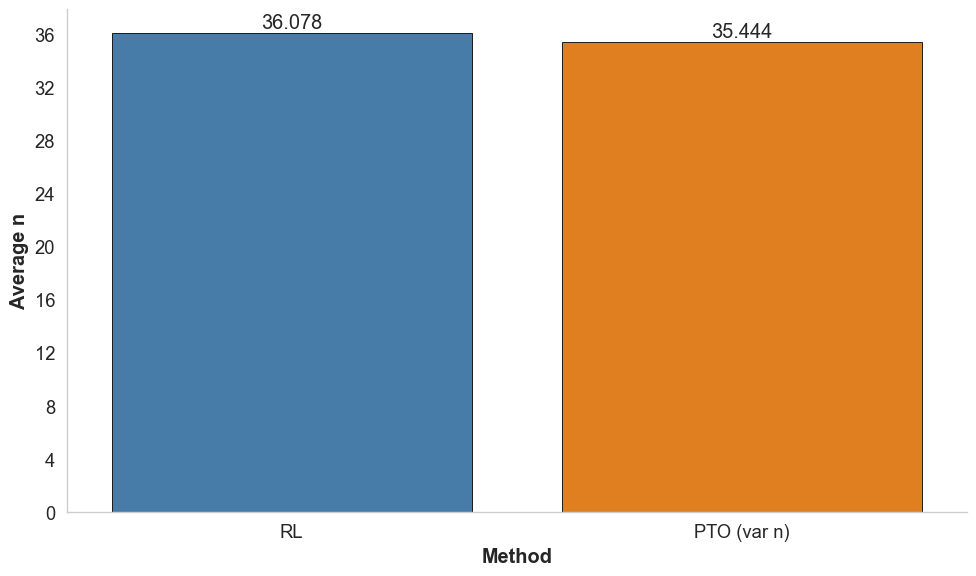

In [12]:
for row in observed_n_results_df.itertuples():
    
    test_name = row._1
    methods_list = list(observed_n_results_df.columns)[1:]
    
    if test_name == "Bicycle Data Test" or test_name == "Prof Data Test":
        methods_list = ['PPO', 'PTO_Var_n']
        
    method_list = [m for m in methods_list if not math.isnan(getattr(row, m))]
    
    observed_ns = [getattr(row, col) for col in methods_list]
    
    
    plt.figure(figsize=(10, 6))
    
    short_labels = [method_map[m] for m in methods_list]
    
    colors = [color_map[m] for m in methods_list]

   
    ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)
    ax.set_ylabel('Average n')
    ax.set_xlabel('Method')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(False)
    
    sns.despine()
   
   
    for i, v in enumerate(observed_ns):
        ax.text(i, v + 0.05, f"{v:.3f}", ha='center', va='bottom')
    
    plt.tight_layout()
    
    config = sim_tests.get(test_name)
    
    file_name = f'observed_n_comparison_{test_name.replace(" ", "_").lower()}'
    plt.savefig(methods.file_path(f'{file_name}.png', dir_name='figures'))
    json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
    plt.show()

## Obeserved n Compiled plot

,Test Name,Method,Average n
0,low alpha from 0.1 to 1.0 with uniform travel ...,PPO,6.2107
1,medium alpha from 1.0 to 3.0 with uniform trav...,PPO,10.1598
2,high alpha from 3.0 to 5.0 with uniform travel...,PPO,11.3860
3,high beta from 3 to 5 with uniform travel time,PPO,9.8349
4,low alpha from 0.1 to 1.0 with low travel time,PPO,10.1325


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_76929/3185387360.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i for i in range(1, 13)])


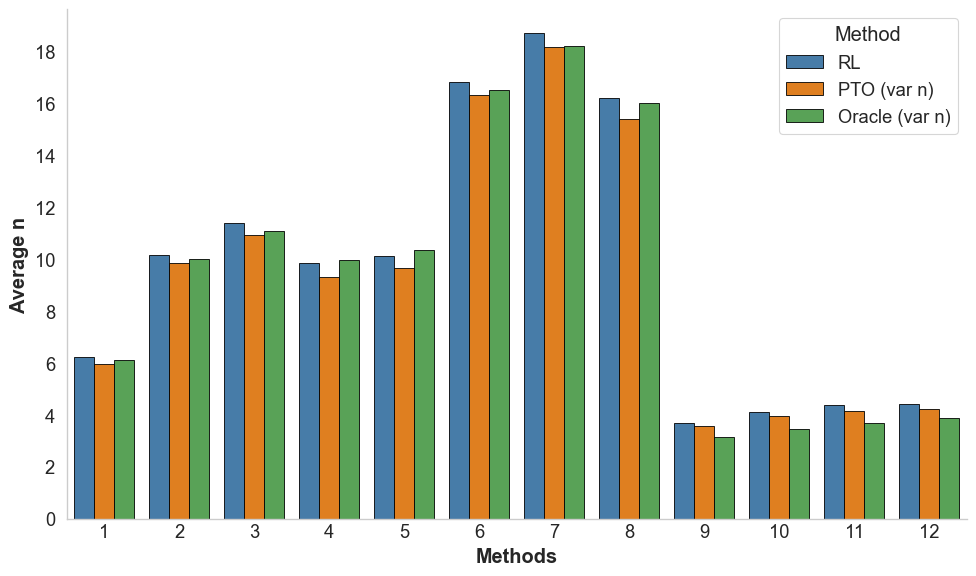

<Figure size 640x480 with 0 Axes>

In [13]:
# obersved n compiled plot

# Preserve 'Test Name' so it can be used on x-axis
observed_n_results_df_melted = observed_n_results_df.melt(
	id_vars='Test Name',
	var_name='Method',
	value_name='Average n'
)
display(observed_n_results_df_melted.head())
observed_n_results_df_melted = observed_n_results_df_melted[observed_n_results_df_melted['Test Name'].str.contains('with', na=False)]
sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=observed_n_results_df_melted,
    x='Test Name',
    y='Average n',
    hue='Method',
    palette=color_map,
    edgecolor='black',
    linewidth=0.6
)
ax.set_ylabel('Average n')
ax.set_xlabel('Methods')
ax.set_xticklabels([i for i in range(1, 13)])
ax.tick_params(axis='x', length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
mapped_labels = [method_map.get(l, l) for l in labels]
legend = ax.legend(handles, mapped_labels, title='Method')
plt.tight_layout()
plt.show()
plt.savefig(methods.file_path('observed_n_comparison_compiled.png', dir_name='figures'))


## u* Comparision with alpha and beta

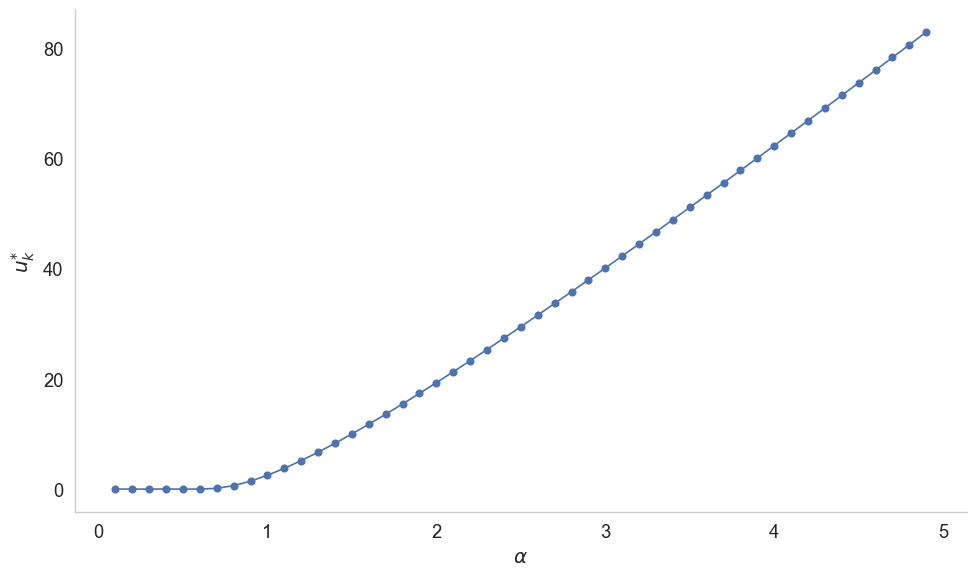

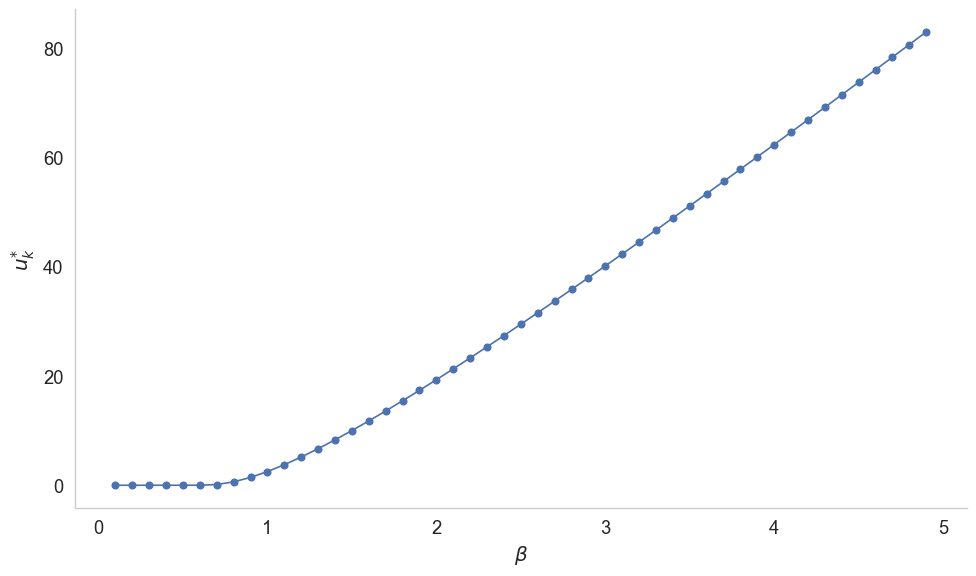

In [14]:
# u* vs alpha plot
config = {
    'k': 10,
    'alpha_range': np.arange(0.1, 5, 0.1).tolist(),
    'beta': 2,
    'h': 0.5,
    'c': 25,
}
u_values = [methods.get_u_star_binary_fast(alpha, config['beta'], config['k'], config['h'], config['c']) for alpha in config['alpha_range']]

# plot u* vs alpha
plt.figure(figsize=(10, 6))
plt.plot(config['alpha_range'], u_values, marker='o')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$u_k^{*}$")
plt.grid()
plt.tight_layout()
sns.despine()
file_name = 'u_star_vs_alpha'
json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
plt.savefig(methods.file_path('u_star_vs_alpha.png', dir_name='figures'))
plt.show()


# u* vs beta plot
config = {
    'k': 10,
    'alpha': 2,
    'beta_range': np.arange(0.1, 5, 0.1).tolist(),
    'h': 0.5,
    'c': 25,
}
u_values = [methods.get_u_star_binary_fast(config['alpha'], beta, config['k'], config['h'], config['c']) for beta in config['beta_range']]
# plot u* vs beta
plt.figure(figsize=(10, 6))
plt.plot(config['beta_range'], u_values, marker='o')
plt.xlabel(r"$\beta$")
plt.ylabel(r"$u_k^{*}$")
plt.grid()
plt.tight_layout()
sns.despine()
file_name = 'u_star_vs_beta'
json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
plt.savefig(methods.file_path('u_star_vs_beta.png', dir_name='figures'))
plt.show()
